# Milestone 5: Poiseuille Flow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.simulation as sim
import src.boundary as bdry
import sys
from tqdm import trange
from scipy.special import lambertw
from scipy.stats import linregress

## Parameters

In [2]:
size_x = 120
size_y = 50
n_steps = 10000
omega = 1.0
density_in = 1.005
density_out = 0.995

## Initialize

In [3]:
lattice = sim.LatticeBoltzmann(size_x, size_y, omega=omega, init_density=np.ones((size_y, size_x)),
                               boundaries=[bdry.PeriodicPressureGradientBoundaryCondition("h", [density_in, density_out]),
                                           bdry.RigidWallBoundaryCondition("tb")],
                               plot=False, animate=False)

## Run Simulation and take Measurements

In [4]:
velocity_field = np.empty((n_steps+1, 2, size_y, size_x))
velocity_field[0] = lattice.velocity
for i in trange(n_steps, file=sys.stdout):
    lattice.step()
    velocity_field[i+1] = lattice.velocity

100%|██████████| 10000/10000 [00:13<00:00, 743.68it/s]


## Plot Results

### Evolution of the Velocity Profile

Analytical solution: $u_x(\cdot, y) = - \frac{1}{2\rho\nu} \frac{dp}{dx} y (L_y - y)$

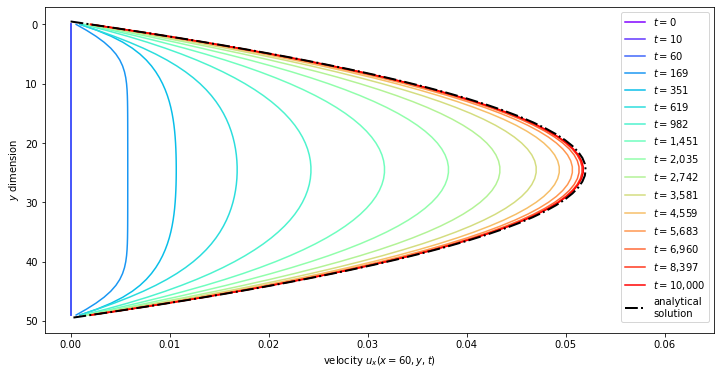

In [5]:
measurement_point = size_x//2
fig, ax = plt.subplots(figsize=(12, 6))
ax.invert_yaxis()
ax.set_xlabel(f"velocity $u_x(x={measurement_point}, y, t)$")
ax.set_ylabel("$y$ dimension")
# steps with exponentially increasing step size
# solve n_steps^(1/b)/b=15 for b to plot exactly 15 steps --> 15 + last = 16 lines
b = np.log(n_steps) / lambertw(15 * np.log(n_steps)).real + 1e-12
steps = np.append((np.arange(np.power(n_steps, 1/b), step=b)**b).astype(int), n_steps)
y_data = np.arange(size_y)
for t in steps:
    x_data = velocity_field[t, 1, :, measurement_point]
    ax.plot(x_data, y_data, color=plt.cm.rainbow(np.power(t/n_steps, 1/b)), label=f"$t=${t:,}")
# analytical solution
y_data = np.append(y_data, size_y)
pressure_derivative_x = (density_out - density_in) / 3.0 / size_x  # p=ρ·c² with c=1/3
dynamic_viscosity = lattice.viscosity * lattice.density[:, measurement_point].mean()
analytica_solution = - 0.5 / dynamic_viscosity * pressure_derivative_x * y_data * (size_y - y_data)
ax.plot(analytica_solution, y_data-0.5, "k-.", linewidth=2, label="analytical\nsolution")
ax.set_xlim(xmax=np.max(analytica_solution)*1.25)
ax.legend()
plt.show()

### Flow Field/Streamlines

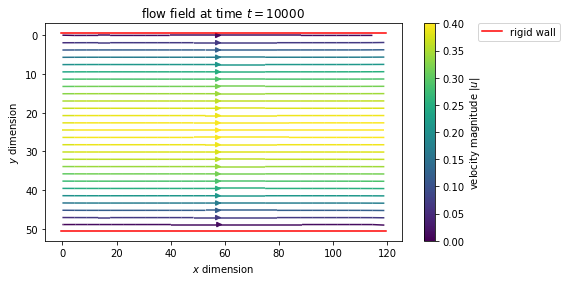

In [6]:
n_cols = 4
n_rows = len(steps) // n_cols
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(f"flow field at time $t={t}$")
ax.set_ylabel("$y$ dimension")
ax.set_xlabel("$x$ dimension")
ax.invert_yaxis()
x, y, v, u = np.arange(size_x), np.arange(size_y), velocity_field[-1, 0], velocity_field[-1, 1]
ax.streamplot(x, y, u, v, color=u, density=0.9)
ax.plot([-0.5, size_x-0.5], [-0.5, -0.5], color="red")
ax.plot([-0.5, size_x-0.5], [size_y+0.5, size_y+0.5], color="red", label="rigid wall")
ax.legend(bbox_to_anchor=(1.2, 1.025), loc="upper left")
fig.colorbar(plt.cm.ScalarMappable(plt.Normalize(0.0, 0.4), plt.cm.viridis),
             ax=ax, label="velocity magnitude $|u|$")
plt.show()

### Density Gradient along the Centerline

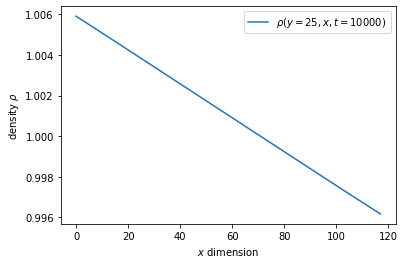

In [7]:
plt.figure()
plt.xlabel("$x$ dimension")
plt.ylabel("density $\\rho$")
plt.plot(lattice.density[size_y//2, 1:-1], label=f"$\\rho(y={size_y//2}, x, t={n_steps})$")
plt.legend()
plt.show()

In [8]:
gradient_empirical = linregress(np.arange(size_x-2), lattice.density[size_y//2, 1:-1]).slope / 3.0
gradient_analytical = (density_out - density_in) / 3.0 / size_x
print(f"Empirical pressure gradient:  dp/dx = {gradient_empirical}")
print(f"Analytical pressure gradient: dp/dx = {gradient_analytical}")

Empirical pressure gradient:  dp/dx = -2.7818203989206054e-05
Analytical pressure gradient: dp/dx = -2.7777777777777495e-05


### Area of the Velocity Profile

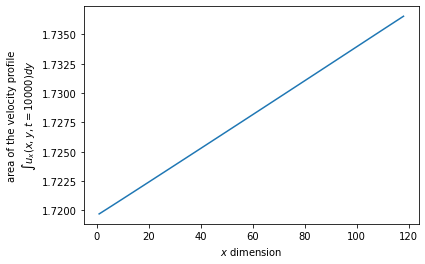

Area increase from left to right: ~0.979%


In [9]:
plt.figure()
plt.xlabel("$x$ dimension")
plt.ylabel(f"area of the velocity profile\n$\int u_x(x, y, t={n_steps}) dy$")
x_data = np.arange(1, size_x-1)
y_data = np.array([np.sum(velocity_field[n_steps, 1, :, x]) for x in x_data])
plt.plot(x_data, y_data)
plt.show()
area_increase_percent = (y_data[-1] / y_data[0] - 1) * 100
print(f"Area increase from left to right: ~{area_increase_percent:.3f}%")